In [1]:
# generate association rule
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from collections import defaultdict
from tqdm import tqdm

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import MultiLabelBinarizer


# Function to encode a chunk of transactions
def encode_transactions(transactions, te):
    te_ary = te.transform(transactions)
    return pd.DataFrame(te_ary, columns=te.columns_)

# Initialize TransactionEncoder
te = TransactionEncoder()

# Parameters
chunk_size = 60000  # Adjust chunk size to your system's memory limit
min_support = 0.05  # Adjust the minimum support value as needed
total_transactions = 0  # Keep track of total number of transactions
all_items_set = set()  # This will hold all unique items
selected_columns = ['salesperson_name', 'property_type', 'transaction_type', "represented"]  # Example columns from your dataset

# First pass: create the set of all unique items
for chunk in tqdm(pd.read_csv("CEASalespersonsPropertyTransactionRecordsresidential.csv", chunksize=chunk_size, usecols=selected_columns)):
    # Convert columns to string to create unique items
    chunk = chunk.astype(str)
    transactions = chunk[selected_columns].values.tolist()
    all_items_set.update([item for sublist in transactions for item in sublist])

# Fit the TransactionEncoder to all items
te.fit([list(all_items_set)])

# Initialize dictionary to keep track of itemset support across all chunks
itemset_support_dict = defaultdict(int)

# Second pass: read the CSV file in chunks and process each chunk
for chunk in tqdm(pd.read_csv("CEASalespersonsPropertyTransactionRecordsresidential.csv", chunksize=chunk_size, usecols=selected_columns)):
    # Convert columns to string to create unique items
    chunk = chunk.astype(str)
    transactions = chunk[selected_columns].values.tolist()
    df_encoded = encode_transactions(transactions, te)
    chunk_frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    for index, row in chunk_frequent_itemsets.iterrows():
        itemset = frozenset(row['itemsets'])
        support = row['support']
        itemset_support_dict[itemset] += support * len(chunk)
    total_transactions += len(chunk)

# Convert support counts to relative support values
for itemset in itemset_support_dict.keys():
    itemset_support_dict[itemset] /= total_transactions

# Filter itemsets by global support to get the final frequent itemsets
global_frequent_itemsets = {itemset for itemset, support in itemset_support_dict.items() if support >= min_support}

# Display the global frequent itemsets
print(global_frequent_itemsets)

14it [00:01,  7.75it/s]
14it [01:00,  4.33s/it]

{frozenset({'LANDLORD', 'HDB'}), frozenset({'RESALE', 'SELLER'}), frozenset({'CONDOMINIUM_APARTMENTS', 'WHOLE RENTAL'}), frozenset({'ROOM RENTAL', 'LANDLORD'}), frozenset({'WHOLE RENTAL', 'HDB'}), frozenset({'TENANT'}), frozenset({'RESALE', 'HDB'}), frozenset({'CONDOMINIUM_APARTMENTS', 'WHOLE RENTAL', 'TENANT'}), frozenset({'RESALE', 'HDB', 'SELLER'}), frozenset({'WHOLE RENTAL', 'TENANT'}), frozenset({'HDB'}), frozenset({'BUYER', 'HDB'}), frozenset({'ROOM RENTAL'}), frozenset({'CONDOMINIUM_APARTMENTS', 'TENANT'}), frozenset({'CONDOMINIUM_APARTMENTS'}), frozenset({'LANDLORD', 'HDB', 'WHOLE RENTAL'}), frozenset({'WHOLE RENTAL'}), frozenset({'HDB', 'SELLER'}), frozenset({'CONDOMINIUM_APARTMENTS', 'LANDLORD', 'WHOLE RENTAL'}), frozenset({'CONDOMINIUM_APARTMENTS', 'SELLER'}), frozenset({'BUYER'}), frozenset({'LANDLORD', 'WHOLE RENTAL'}), frozenset({'SELLER'}), frozenset({'BUYER', 'RESALE', 'HDB'}), frozenset({'CONDOMINIUM_APARTMENTS', 'LANDLORD'}), frozenset({'RESALE'}), frozenset({'BUYER',

In [2]:
print(global_frequent_itemsets)

{frozenset({'LANDLORD', 'HDB'}), frozenset({'RESALE', 'SELLER'}), frozenset({'CONDOMINIUM_APARTMENTS', 'WHOLE RENTAL'}), frozenset({'ROOM RENTAL', 'LANDLORD'}), frozenset({'WHOLE RENTAL', 'HDB'}), frozenset({'TENANT'}), frozenset({'RESALE', 'HDB'}), frozenset({'CONDOMINIUM_APARTMENTS', 'WHOLE RENTAL', 'TENANT'}), frozenset({'RESALE', 'HDB', 'SELLER'}), frozenset({'WHOLE RENTAL', 'TENANT'}), frozenset({'HDB'}), frozenset({'BUYER', 'HDB'}), frozenset({'ROOM RENTAL'}), frozenset({'CONDOMINIUM_APARTMENTS', 'TENANT'}), frozenset({'CONDOMINIUM_APARTMENTS'}), frozenset({'LANDLORD', 'HDB', 'WHOLE RENTAL'}), frozenset({'WHOLE RENTAL'}), frozenset({'HDB', 'SELLER'}), frozenset({'CONDOMINIUM_APARTMENTS', 'LANDLORD', 'WHOLE RENTAL'}), frozenset({'CONDOMINIUM_APARTMENTS', 'SELLER'}), frozenset({'BUYER'}), frozenset({'LANDLORD', 'WHOLE RENTAL'}), frozenset({'SELLER'}), frozenset({'BUYER', 'RESALE', 'HDB'}), frozenset({'CONDOMINIUM_APARTMENTS', 'LANDLORD'}), frozenset({'RESALE'}), frozenset({'BUYER',

In [3]:
# This is for part3

import numpy as np

df = pd.read_csv("CEASalespersonsPropertyTransactionRecordsresidential.csv")

# Define the columns that you consider as items for the Apriori algorithm
selected_columns = ['salesperson_name', 'property_type', 'transaction_type', "represented"]

# Create transactions: Each transaction is a list of items
all_transactions = df.apply(lambda x: x.tolist(), axis=1).tolist()


def encode_frequent_itemsets(transactions, frequent_itemsets):
    encoded_data = []
    for transaction in transactions:
        transaction_set = set(transaction)
        encoded_row = [int(itemset.issubset(transaction_set)) for itemset in frequent_itemsets]
        encoded_data.append(encoded_row)
    return np.array(encoded_data)
encoded_matrix = encode_frequent_itemsets(all_transactions, global_frequent_itemsets)


To use frequent itemsets for clustering, you need to transform your data in a way that reflects the presence of these frequent itemsets in each transaction. This approach is different from the earlier method where individual items were considered. Here, each frequent itemset is treated as a feature, and transactions are encoded based on the presence or absence of these itemsets.


Create a Binary Matrix for Frequent Itemsets: Similar to before, create a binary matrix where each row represents a transaction and each column represents one of the frequent itemsets. The value is 1 if the transaction contains the itemset, and 0 otherwise.

Apply Clustering on this Matrix: Use a clustering algorithm like KMeans on this new binary matrix.

Visualize the Results: Use techniques like PCA for scatter plots or heatmaps to visualize the clustering results.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

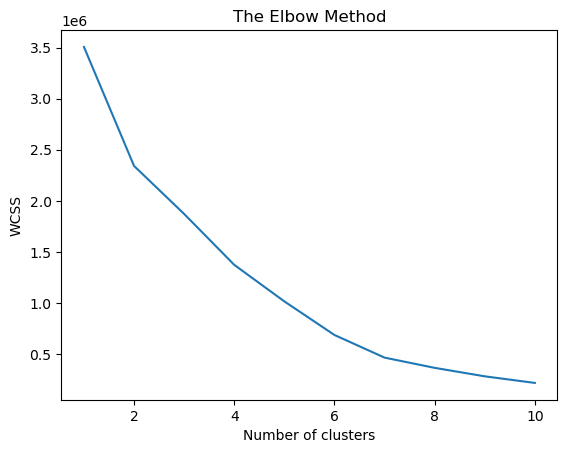

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
wcss = []
for i in range(1, 11):  # testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(encoded_matrix)  # encoded_matrix from your previous step
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph to observe 'The Elbow'
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()


The image you've uploaded appears to show the result of the Elbow Method rather than the Silhouette Score. The Elbow Method graph typically plots the within-cluster sum of squares (WCSS) against the number of clusters. The "elbow" point in the graph is typically considered as a good choice for the number of clusters because it indicates the point at which adding more clusters does not significantly improve the fit of the model.

From the image you provided, it appears that the WCSS decreases sharply up to 4 clusters and then starts to level off. This suggests that the elbow point is at 4 clusters. Thus, you may want to consider choosing 4 clusters for your KMeans clustering.

However, to make a more informed decision, you should also consider the Silhouette Score, which provides insight into the separation distance between the resulting clusters. A higher Silhouette Score indicates better-defined clusters. If you have that graph or the values, you should consider it in conjunction with the Elbow Method to determine the optimal number of clusters. If the Silhouette Score is highest at the same number of clusters suggested by the Elbow Method, it would reinforce the decision to choose that number of clusters.

### Can tune PCA input, If we can be used for part 4 ?

In [4]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans_labels = kmeans.fit_predict(encoded_matrix)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [5]:
clustered_df = pd.DataFrame({
    'KMeans_Cluster': kmeans_labels,
})
print(clustered_df)

        KMeans_Cluster
0                    1
1                    3
2                    3
3                    1
4                    1
...                ...
799853               2
799854               2
799855               0
799856               0
799857               1

[799858 rows x 1 columns]


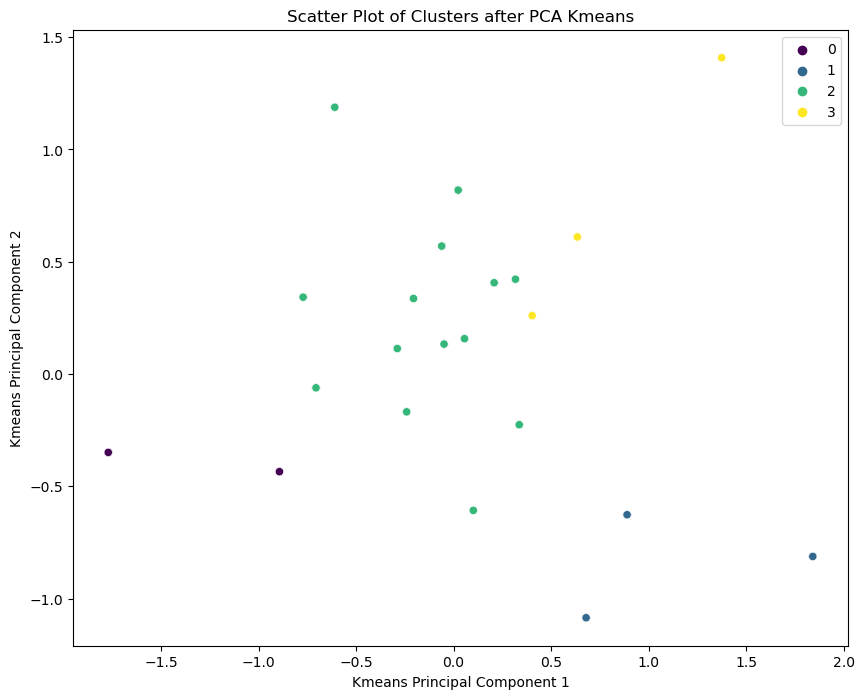

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce the dimensions to 2 for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(encoded_matrix)

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=kmeans_labels, palette="viridis")
plt.title("Scatter Plot of Clusters after PCA Kmeans")
plt.xlabel("Kmeans Principal Component 1")
plt.ylabel("Kmeans Principal Component 2")
plt.show()


The scatter plot of the PCA-reduced data with four clusters shows the separation between the clusters in the first two principal components. From the image you have uploaded, here are some observations:

Cluster Separation: It seems that there is a reasonable separation between the clusters, which suggests that the PCA has managed to reduce the dimensions of the data while still retaining some of the structure necessary for clustering.

Cluster Density: Some clusters appear to be more densely packed, while others are more spread out. For example, the clusters represented by yellow and purple points seem to have a tighter grouping than the others. This may indicate differences in the variance within each cluster.

Outliers: There are a few points that are distant from the main cluster groups. These could be outliers in the dataset, or they could represent unique or rare combinations of features within the transactions.

Overlap: There is some overlap between the clusters, particularly noticeable between clusters 0 and 2 (grey and green points). This could imply that there are some transactions with features that are not clearly distinct between these clusters.

Conclusions:

The choice of four clusters seems to have led to a meaningful grouping, with each cluster being distinct to some extent.
The overlap between clusters may require further investigation. You might want to look into the characteristics of the transactions that are near the boundaries between clusters.
The presence of outliers could be significant, depending on the context of the data. If these transactions are errors or anomalies, they may need to be treated separately.
The PCA has done a decent job of dimensionality reduction, but keep in mind that it is a linear technique. If the data has nonlinear relationships, other dimensionality reduction techniques such as t-SNE or UMAP might reveal more structure.
In conclusion, this visualization suggests that the four-cluster solution is a reasonable starting point, but depending on your specific goals and the context of the data, you may want to further analyze the cluster characteristics and consider if a different number of clusters or a different clustering algorithm might yield more insightful results.

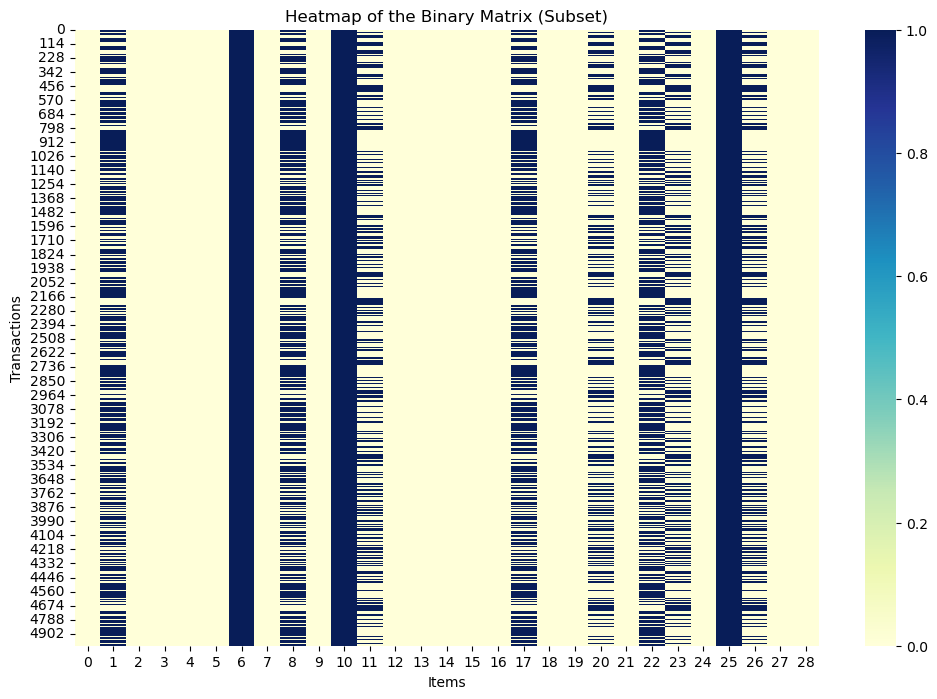

In [7]:
subset_data = encoded_matrix[:5000]  # Adjust this based on your data size

plt.figure(figsize=(12, 8))
sns.heatmap(subset_data, cmap="YlGnBu")
plt.title("Heatmap of the Binary Matrix (Subset)")
plt.xlabel("Items")
plt.ylabel("Transactions")
plt.show()

The heatmap you've provided visualizes a subset of the binary matrix that represents your encoded transactions, with rows corresponding to transactions and columns representing items or itemsets.

From the heatmap:

Dense Columns: The columns that are densely populated with dark blue indicate items or itemsets that are present in many transactions. If these are the frequent itemsets, it shows that they indeed occur frequently across the dataset.

Sparse Columns: Columns with few dark blue marks are items or itemsets that occur less frequently. This could indicate more unique or rare items/itemsets in the dataset.

Transaction Patterns: Looking across a row, you can identify the combination of items that occur together in individual transactions. Rows with more blue indicate transactions with more items present, while rows with less blue are simpler transactions with fewer items.

Clustering of Transactions: If certain rows (transactions) show similar patterns of blue and light colors, this suggests that those transactions are similar to each other, potentially indicating the existence of clusters within the data.

Conclusions:

The heatmap confirms the presence of frequent itemsets within the dataset. These could be the focus for targeted marketing strategies or stock management if this were a retail dataset, for example.

The visualization also highlights the variability in the transactions, with some transactions containing many items and others containing fewer.

While the heatmap shows individual transactions, it does not directly show the clusters determined by the KMeans algorithm. To visualize the clustering, you might want to rearrange the rows based on the cluster labels to see if transactions within the same cluster exhibit similar itemset patterns.

The heatmap can be a useful tool for exploratory data analysis, providing a quick visual summary of the data's structure. However, for more detailed insights, further statistical analysis might be required.

In terms of actionable insights, one might consider examining the densest columns to understand which items or itemsets are most common and could therefore be crucial for business strategies. Additionally, further analysis might explore why certain items are rarely bought together or how to increase the transaction size for those simpler transactions.

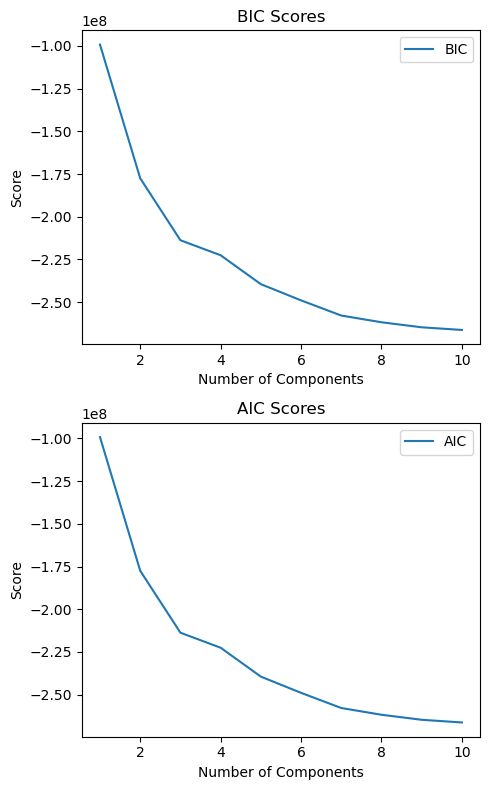

In [26]:
#GaussianMixture clustering

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'encoded_matrix' is available from the earlier step
# and is the binary matrix representing the transactions encoded with itemsets.

# Define a range of number of components to try
n_components_range = range(1, 11)

# Lists to store the BIC and AIC values
bics = []
aics = []

# Calculate BIC and AIC for each number of components
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(encoded_matrix)
    bics.append(gmm.bic(encoded_matrix))
    aics.append(gmm.aic(encoded_matrix))
    ratio.append(gmm.bic(encoded_matrix)/gmm.aic(encoded_matrix))

# Plot the BIC and AIC values
plt.figure(figsize=(5, 8))

plt.subplot(2, 1, 1)
plt.plot(n_components_range, bics, label='BIC')
plt.title('BIC Scores')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(n_components_range, aics, label='AIC')
plt.title('AIC Scores')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()


The plots you've provided for the Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC) both show a similar trend: the scores decrease as the number of components increases, without a clear "elbow" or leveling-off point which would indicate an optimal number of clusters.

In scenarios like this, it's often advisable to choose the number of components where the decrease in BIC or AIC begins to slow down, balancing model complexity with goodness of fit. From the plots, it appears that the slope of both the BIC and AIC starts to flatten out after 2 components, but there isn't a significant change in the rate of decrease after that point.

Choosing between BIC and AIC can depend on your preference for model complexity (BIC penalizes complexity more than AIC). If a simpler model is preferred due to considerations such as interpretability or computational efficiency, you might opt for fewer clusters. On the other hand, if the goal is to capture as much variability in the data as possible, a larger number of clusters could be justified.

Given these considerations, a model with 2 or 3 components might be a good compromise for your clustering task. However, the final choice should also be guided by the practical implications of the clustering, such as how the results will be used and whether the clusters will be interpretable and actionable in your specific context.

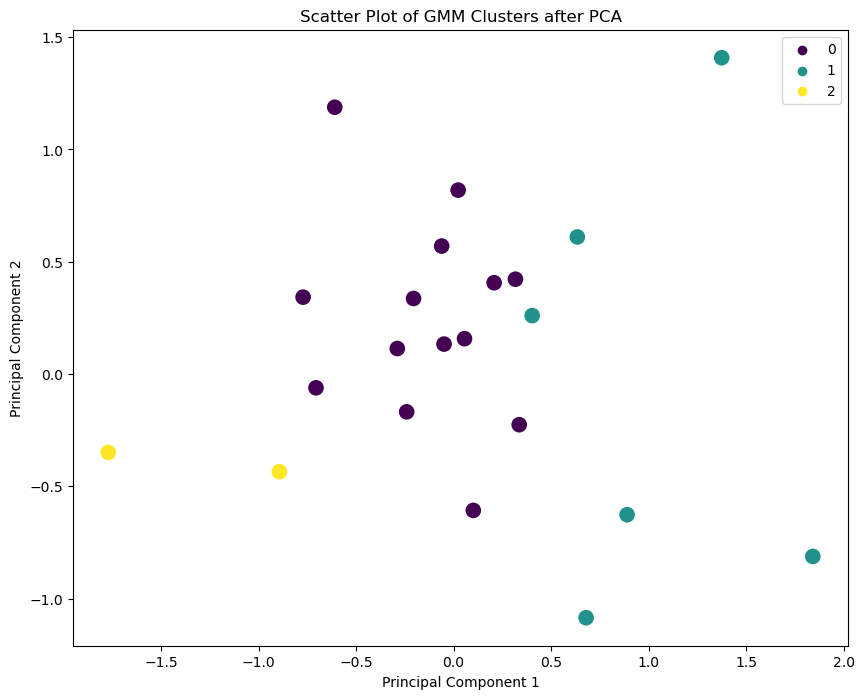

In [19]:
from sklearn.mixture import GaussianMixture

# Choose the number of components based on your previous analysis with KMeans
n_components = 3

# Initialize the GaussianMixture model
gmm = GaussianMixture(n_components=n_components, random_state=42)

# Fit the model and predict the cluster labels
gmm_labels = gmm.fit_predict(encoded_matrix)

# You can also access the probabilities that a point belongs to a cluster
probs = gmm.predict_proba(encoded_matrix)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce the dimensions to 2 for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(encoded_matrix)

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=gmm_labels, palette="viridis",s=150)
plt.title("Scatter Plot of GMM Clusters after PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# plt.figure(figsize=(14, 7))
# sns.heatmap(probs[:5000], cmap="viridis")  # Adjust as needed for your dataset size
# plt.title("Probability Heatmap of Clusters (Subset)")
# plt.xlabel("Cluster")
# plt.ylabel("Data point index")
# plt.show()


## This can be use for Our part 4 for tuning

In [10]:
from sklearn.cluster import MiniBatchKMeans
import time



before_kmeans = time.time()
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans_labels = kmeans.fit_predict(encoded_matrix)
after_kmeans = time.time()

print(f"kmean time {after_kmeans - before_kmeans}")


before_minikmeans = time.time()
mini_kmeans = MiniBatchKMeans(n_clusters=4, random_state=0, batch_size=1000)
mini_kmeans_labels = mini_kmeans.fit_predict(encoded_matrix)
after_minikmeans = time.time()
print(f"kmean time {after_minikmeans - before_minikmeans}")


clustered_df = pd.DataFrame({
    'KMeans_Cluster': kmeans_labels,
    'miniKMeans_Cluster': mini_kmeans_labels,
})
print(clustered_df)
# Create a scatter plot



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


kmean time 2.621508836746216


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


kmean time 0.3325176239013672
        KMeans_Cluster  miniKMeans_Cluster
0                    1                   1
1                    3                   2
2                    3                   2
3                    1                   1
4                    1                   1
...                ...                 ...
799853               2                   3
799854               2                   3
799855               0                   0
799856               0                   0
799857               1                   1

[799858 rows x 2 columns]


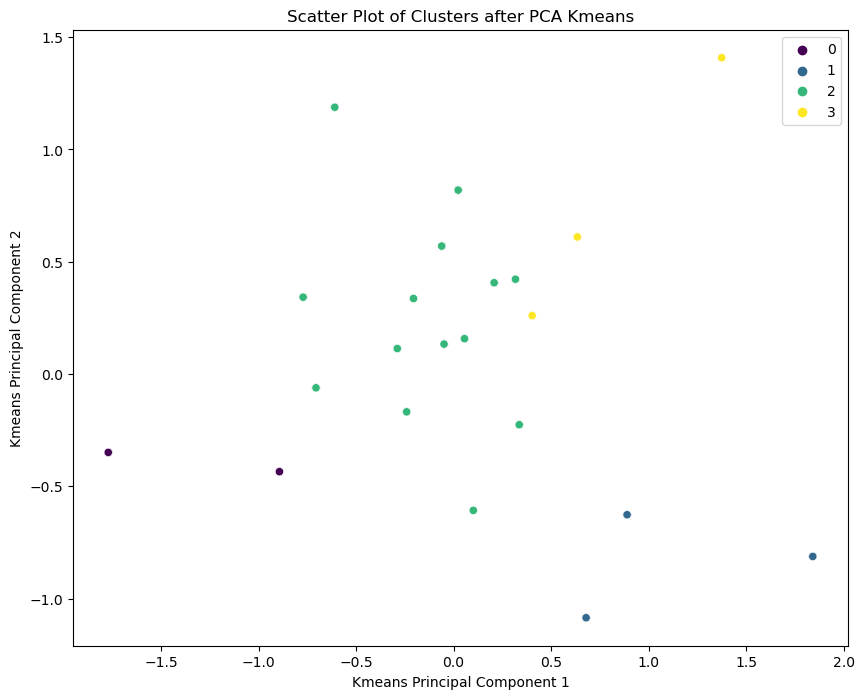

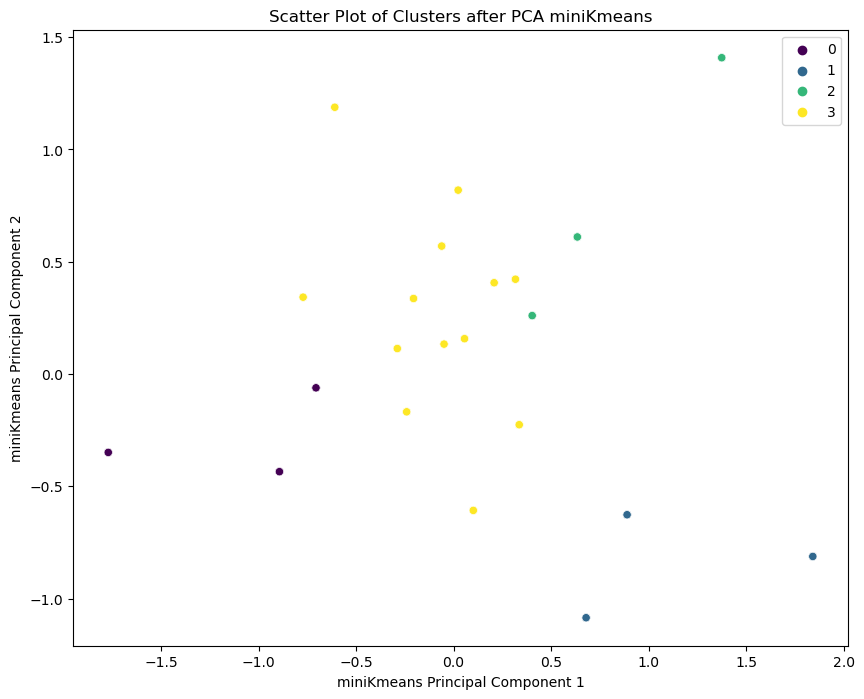

In [11]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(encoded_matrix)

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=kmeans_labels, palette="viridis")
plt.title("Scatter Plot of Clusters after PCA Kmeans")
plt.xlabel("Kmeans Principal Component 1")
plt.ylabel("Kmeans Principal Component 2")
plt.show()

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(encoded_matrix)

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=mini_kmeans_labels, palette="viridis")
plt.title("Scatter Plot of Clusters after PCA miniKmeans")
plt.xlabel("miniKmeans Principal Component 1")
plt.ylabel("miniKmeans Principal Component 2")
plt.show()

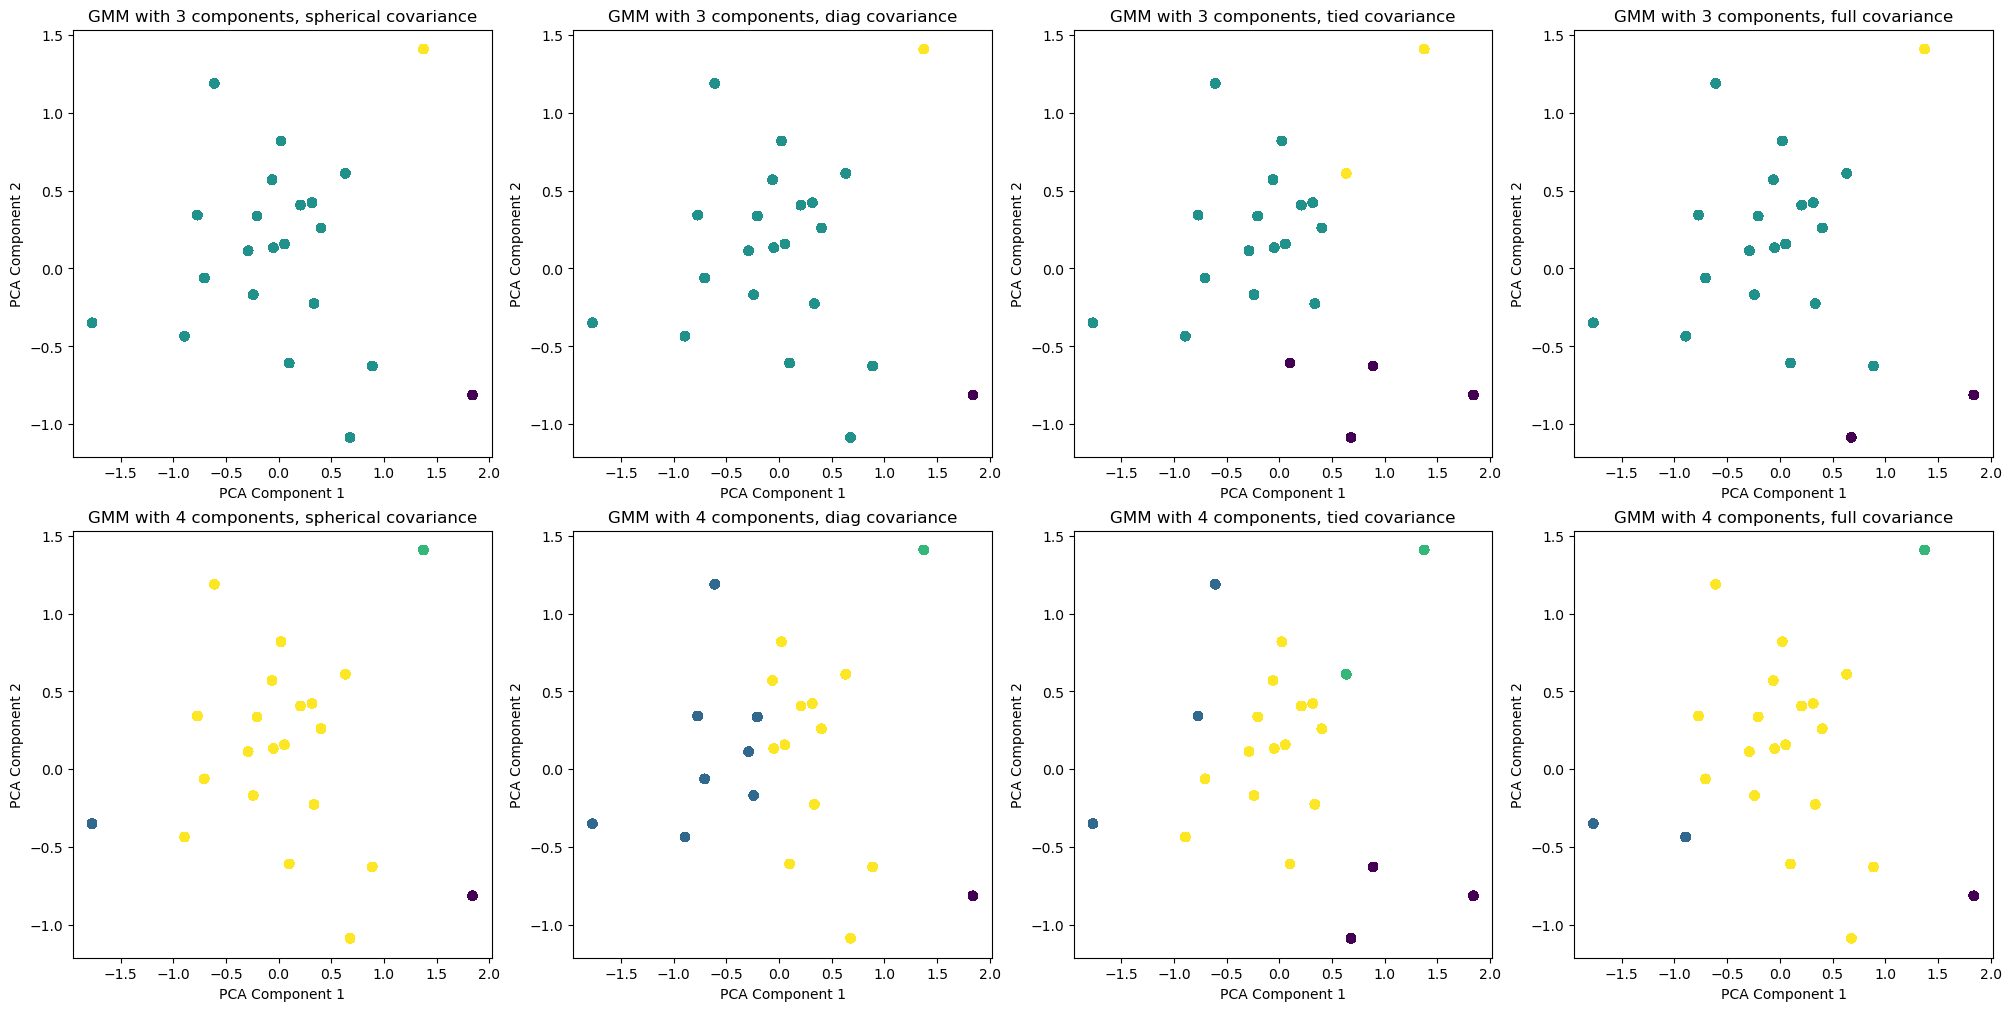

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# Perform PCA for dimensionality reduction for a 2D scatter plot
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(encoded_matrix)

n_components_range = range(3, 5)  # Example: testing 1-7 components
covariance_types = ['spherical', 'diag', 'tied', 'full']


# Create a subplot grid
fig, axes = plt.subplots(len(n_components_range), len(covariance_types), figsize=(20, 10), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each combination of n_components and covariance_type
for idx, (n_components, covariance_type) in enumerate([(n, cv_type) for n in n_components_range for cv_type in covariance_types]):
    # Fit a Gaussian mixture with EM
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=0)
    gmm.fit(reduced_data)
    gmm_labels = gmm.predict(reduced_data)

    # Plot the PCA-reduced data with GMM cluster labels
    axes[idx].scatter(reduced_data[:, 0], reduced_data[:, 1], c=gmm_labels, cmap='viridis', marker='o', alpha=0.5)
    
    # Annotate the plot with the number of components and covariance type
    axes[idx].set_title(f'GMM with {n_components} components, {covariance_type} covariance')
    axes[idx].set_xlabel('PCA Component 1')
    axes[idx].set_ylabel('PCA Component 2')

# Show the plots
plt.show()